# Neural network lecture demo/Lab

In this demo we will use MLP to predict the orientation of a face in a 32 by 32 pixel image. The data set used is from: [Chaper 4 of Machine Learning book by Tom Mitchell](http://www.cs.cmu.edu/~tom/faces.html)

The faces of 20 different people are captured at 4 orientations: Left, Right, Up, Straight. Images from each individual is in a separate folder and the label (orientation) for a specific image is given by the image name.  `glickman_up_neutral_sunglasses.pgm -> up`

In [3]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

import pandas as pd

tf.__version__


'1.15.2'

Load the Face dataset. The dataset can be downloaded from canvas. You can upload it to the notebook work environment and unzip using the following code. 

In [4]:
# import zipfile
# with zipfile.ZipFile('./faces_TM.zip', 'r') as zip_ref:
#     zip_ref.extractall('./')

Split the validation-training data. A good practice would be to hold out some individuals for validation. This will eliminate possible overlaps between train/test splits. Lets hold out the last 5 individuals for testing.

In [5]:
test_persons = ['sz24', 'megak', 'night', 'choon', 'kawamura']

Iterate through the sub folders and read all the image names and create a data frame with relevant information that can be used for training and testing the MLP. 

In [6]:
from PIL import Image
import glob
image_list = []
for filepath in glob.glob('./faces_TM/*/*.jpg', recursive=True): #assuming gif
    filename = filepath.split("/")[-1]
    person = filepath.split("/")[-2]
    label = filename.split("_")[1]
    # print(filepath, person, label)
    test_train = person in test_persons
    image_list.append((filepath, label, int(test_train)))
    
# Create a data frame
data = pd.DataFrame(data=image_list, columns=['image_path', 'label', 'isTest'])

Lets plot some random images and observe

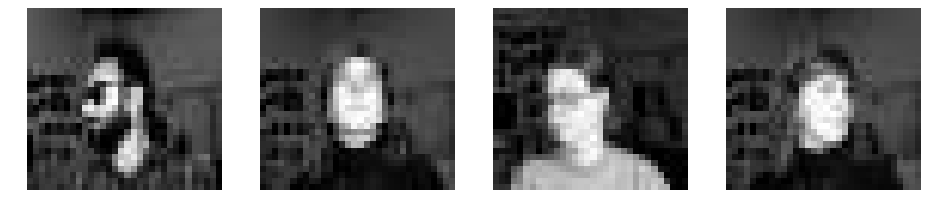

In [7]:
r_inx = np.random.choice(100, 4)
rand_data = data.loc[r_inx,'image_path']

plt.figure(figsize=(16,4))
for i, image_path in enumerate(rand_data):
    im = np.asarray(Image.open(image_path))
    plt.subplot(1,4,i+1)
    plt.imshow(im,cmap='gray')
    plt.axis('off')
    
plt.show()

Convert string labels to numeric

In [8]:
d = {'left':0, 'right':1, 'straight':2, 'up':3}
data['labels_num'] = data['label'].map(d, na_action='ignore')

Generate two data frames for training and validation

In [9]:
train_df = data[data['isTest']==0].reset_index()
validation_df = data[data['isTest']==1].reset_index()
print('Train size: {}, Test size: {}'.format(train_df.shape[0], validation_df.shape[0] ) )
N_train_images = train_df.shape[0]
N_val_images = validation_df.shape[0]

Train size: 469, Test size: 155
     index                                         image_path     label  \
0        0  ./faces_TM/steffi/steffi_right_happy_sunglasse...     right   
1        1  ./faces_TM/steffi/steffi_straight_angry_sungla...  straight   
2        2  ./faces_TM/steffi/steffi_left_happy_sunglasses...      left   
3        3  ./faces_TM/steffi/steffi_straight_happy_open_4...  straight   
4        4     ./faces_TM/steffi/steffi_up_neutral_open_4.jpg        up   
5        5    ./faces_TM/steffi/steffi_right_happy_open_4.jpg     right   
6        6  ./faces_TM/steffi/steffi_straight_neutral_sung...  straight   
7        7       ./faces_TM/steffi/steffi_left_sad_open_4.jpg      left   
8        8  ./faces_TM/steffi/steffi_straight_angry_open_4...  straight   
9        9  ./faces_TM/steffi/steffi_left_angry_sunglasses...      left   
10      10   ./faces_TM/steffi/steffi_up_sad_sunglasses_4.jpg        up   
11      11  ./faces_TM/steffi/steffi_left_neutral_sunglass...      l

We will now design and train an extremely simple neural network.
Two of the choices are made for us by the data.
We have 28x28 features and four classes, so the input layer must have 784 units, and the output layer must have 4 units.
We only have to define the hidden layers.
We're only going to have one hidden layer for this project, and we'll give it 64 nodes/neurons/units.

Keras provides two methods to define a model (sequential and functional API) and we are going to use the functional API (sequential is much simpler and you should try by yourself).

In [10]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.metrics import categorical_accuracy

# Input layer
input_ = Input(shape=(28, 28, 3)) # This is the input shape
input_slice = Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))(input_)
x = Flatten()(input_slice)  # This will convert the 28x28 input to a vector of  dimension 784

# Hidden layer
h = Dense(64)(x)
h = Activation('sigmoid')(h)

# Output layer
out_ = Dense(4)(h)
out_ = Activation('softmax')(out_)

# Define model
model_orig = Model(inputs=input_, outputs=out_)

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_orig.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[categorical_accuracy])


model_orig.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 3)]       0         
_________________________________________________________________
lambda (Lambda)              (None, 28, 28, 1)         0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
activation (Activation)      (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 260       
______________________________________________

Same model with the sequential API (uncomment and try)

In [11]:
# from tensorflow.keras.models import Sequential, Model
# from tensorflow.keras.layers import Conv2D, MaxPooling2D
# from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
# from tensorflow.keras import regularizers, optimizers

# sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
# model_orig = Sequential()
# model_orig.add(Flatten(input_shape=(28, 28, 3)))
# model_orig.add(Dense(64))
# model_orig.add(Activation('sigmoid'))
# model_orig.add(Dense(4))
# model_orig.add(Activation('softmax'))
# model_orig.compile(loss='binary_crossentropy',
#               optimizer=sgd,
#               metrics=[categorical_accuracy])
#
# model_orig.summary()

There are many optimizers that are available but for now, we will use rmsprop.
You will work with other optimizers in experimental section of this tutorial.
Here, we have used categorical_crossentropy because there are more than two categories in the output variable.

As are going to work with much larger and more complicated data set, that neural network are more suited towards, we need to write efficient code to load the data in batches to memory. This is done in keras using Image data generators. 

To help we will define a loading function that takes the data frames we defined earlier:

It seems that dataloader does not like to read one channel images. It automatically converts them to 3-channel images. Lets ignore this for now. 

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 16

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory='./',
        x_col="image_path",
        y_col="label",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=validation_df,
        directory='./',
        x_col="image_path",
        y_col="label",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

Found 469 validated image filenames belonging to 4 classes.
Found 155 validated image filenames belonging to 4 classes.


With this, the training the validation data can be loaded.
You will need to supply the appropriate directory. Usually each pixels varies from 0-255, but it's highly recommended to normalize them in range of 0-1 to speed up the training process.
The dataloader also do a simple normalisation on the pixel values directly.

Now we can use a simple model.fit\_generator() in Keras to train the model. However you will not be doing this. In order to understand the process we will write a function that iterates through the examples and train the model. First we need a function to calculate the accuracy and the loss for a given image stream. 

In [13]:
def calculate_losses(model_in, data_generator_in, N_images, batch_size_):
    loss_hold = []
    acc_hold = []
    batches = 0
    
    # iterate over each batch
    for x,y in data_generator_in:
        loss, acc = model_in.evaluate(x, y, verbose=0)
        loss_hold.append(loss)
        acc_hold.append(acc)
        batches += 1
        if batches >= N_images / batch_size_:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break
            
    return np.mean(loss_hold), np.mean(acc_hold)

Try to understand the above function yourself. 

Next lets write a function to train a model train the model

In [14]:
def train_model(model_, num_epoch=50, verbose=False):
    res = []
    for e in range(num_epoch):
        # print('Epoch', e)
        batches = 0

        loss_ = []
        acc_ = []

         # iterate over each batch
        for x,y in train_generator:
            loss, acc = model_.train_on_batch(x, y) # Update weights and return train loss, acc per batch
            loss_.append(loss)
            acc_.append(acc)
            batches += 1
            if batches >= N_train_images / batch_size:
                # we need to break the loop by hand because
                # the generator loops indefinitely
                break
        loss_ = np.mean(loss_)
        acc_ = np.mean(acc_)

        loss, acc = calculate_losses(model_, validation_generator, N_val_images, batch_size)
        if verbose:
            print("Training epoch {}: Loss = {}, Accuracy = {}".format(e, loss_, acc_))
            print("Validation epoch {}: Loss = {}, Accuracy = {}".format(e, loss, acc))

        res.append((e, loss_, acc_, loss, acc))
    return np.asarray(res)

No we can train the model

In [15]:
res = train_model(model_orig, num_epoch=250, verbose=False)

Lets write a function to plot the results and plot the error loss for the training and accuracy data as well.

In [16]:
def plot_results(res):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(res[:,0], res[:,1], 'r-')
    plt.plot(res[:,0], res[:,3], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.ylim([0, np.max([5., np.max(res[:,1]), np.max(res[:,3])])])

    plt.subplot(1,2,2)
    plt.plot(res[:,0], res[:,2], 'r-')
    plt.plot(res[:,0], res[:,4], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, np.max([1., np.max(res[:,2]), np.max(res[:,4])])])

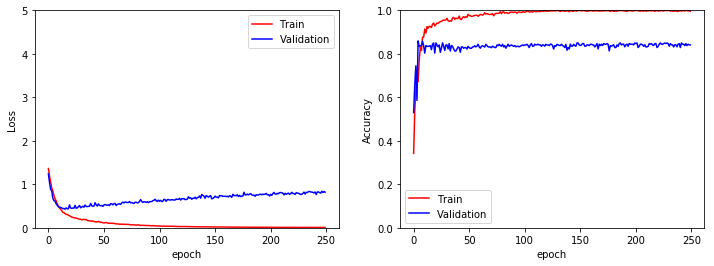

In [17]:
plot_results(res)

Is the above model overfitting?

## Do some regularization

Lets add some ridge penalty and create a new model

In [18]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.metrics import categorical_accuracy


# Input layer
input_ = Input(shape=(28, 28, 3)) # This is the input shape
input_slice = Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))(input_)
x = Flatten()(input_slice)  # This will convert the 28x28 input to a vector of  dimension 784

# Hidden layer
h = Dense(64,kernel_regularizer=regularizers.l2(0.01))(x) # reg for weight matrix 1
h = Activation('sigmoid', name='hidden_layer')(h)

# Output layer
out_ = Dense(4,kernel_regularizer=regularizers.l2(0.01))(h) # reg for weight matrix 2
out_ = Activation('softmax')(out_)

# Define model
model_reg = Model(inputs=input_, outputs=out_)

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_reg.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[categorical_accuracy])


model_reg.summary()

# Creating a model for feature vizualization (will be explained later)
hidden_features = Model(inputs=input_, outputs=h)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 3)]       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                50240     
_________________________________________________________________
hidden_layer (Activation)    (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 260       
_________________________________________________________________
activation_2 (Activation)    (None, 4)                 0   

Train the regularized model

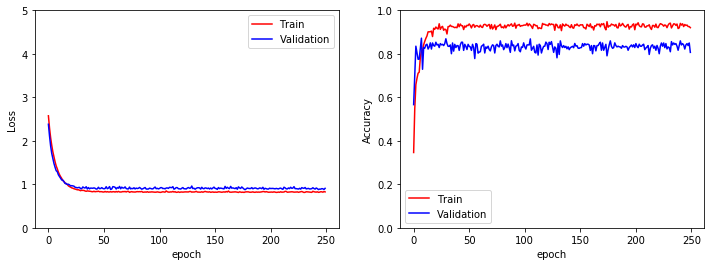

In [19]:
res = train_model(model_reg, num_epoch=250, verbose=False)
plot_results(res)

Is the model still overfitting? How can you tune this parameter to balance overfitting/underfitting

## Try some dropout

Lets create a model with dropput and see if that can also help with overfitting (no regularization)

In [20]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.metrics import categorical_accuracy

# Input layer
input_ = Input(shape=(28, 28, 3)) # This is the input shape
input_slice = Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))(input_)
x = Flatten()(input_slice)  # This will convert the 28x28 input to a vector of  dimension 784

# Hidden layer
h = Dense(64)(x) 
h = Activation('sigmoid')(h)
h= Dropout(rate=0.5)(h)

# Output layer
out_ = Dense(4)(h) 
out_ = Activation('softmax')(out_)

# Define model
model_drop = Model(inputs=input_, outputs=out_)

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_drop.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[categorical_accuracy])


model_drop.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 3)]       0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                50240     
_________________________________________________________________
activation_3 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 260 

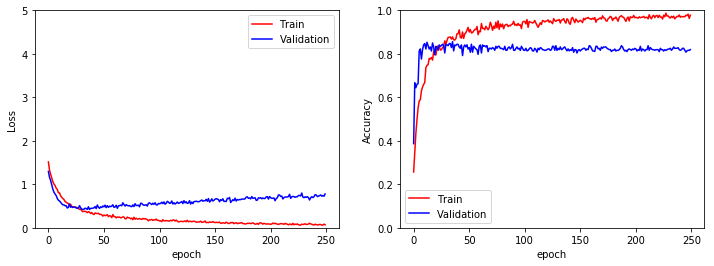

In [21]:
res = train_model(model_drop, num_epoch=250, verbose=False)
plot_results(res)

Try changing the dropout and check if you can reduce overfitting.

## Predict on random images from test set

Since we dont have an independet test set for this data, we will test on the validation set. This is clearly not a good stratergy. 

First we will create a data generator to get the test data

In [22]:
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size_t = 1

# Here the validation is used for testing and this should be changes to a separate test set.
test_generator = train_datagen.flow_from_dataframe(
        dataframe=validation_df,
        directory='./',
        x_col="image_path",
        y_col="label",
        target_size=(28, 28),
        batch_size=batch_size_t,
        class_mode='categorical')


Found 155 validated image filenames belonging to 4 classes.


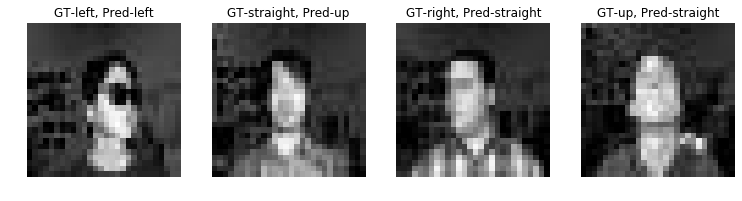

In [23]:
d_inv = {v: k for k, v in d.items()}
plt.figure(figsize=(16,4))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = model_reg.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

## Extract the hidden layer features and vizualize

For extracting features we can generate a new model with the same input as the original model and with the output from the desired layer. I have done this for the regularized model. Check the code block of the regularized model.  

In [24]:
#print layer names
for layer in hidden_features.layers:
    print(layer.name)


def extract_hidden_features(model_, generator_, N_images): 
    batches = 0

    features = []
    inputs = []
    y_ = []

    # iterate over each batch
    for x,y in generator_:
        hf = model_.predict(x) 
        for h in hf:
            features.append(h)
        for yy in y:
            y_.append(np.argmax(yy))
        for xx in x:
            inputs.append(xx.reshape(-1,))

        batches += 1
        if batches >= N_images / batch_size:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break 
    features = np.asarray(features)
    y = np.asarray(y_)
    inputs = np.asarray(inputs)
    
    return inputs, y, features



input_2
lambda_1
flatten_1
dense_2
hidden_layer


Text(0.5, 1.0, 'Input Embedding')

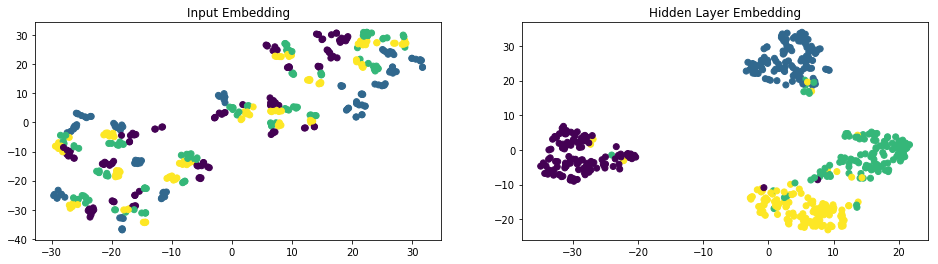

In [25]:
inputs, y, features = extract_hidden_features(hidden_features, train_generator, N_train_images)


from sklearn.manifold import TSNE

plt.figure(figsize=(16,4))
plt.subplot(1,2,2)
features_embedded = TSNE(n_components=2).fit_transform(features)
plt.scatter(features_embedded[:,0], features_embedded[:,1], c=y)
plt.title('Hidden Layer Embedding')

plt.subplot(1,2,1)
inputs_embedded = TSNE(n_components=2).fit_transform(inputs)
plt.scatter(inputs_embedded[:,0], inputs_embedded[:,1], c=y)
plt.title('Input Embedding')

Now lets plot for test data

Text(0.5, 1.0, 'Input Embedding')

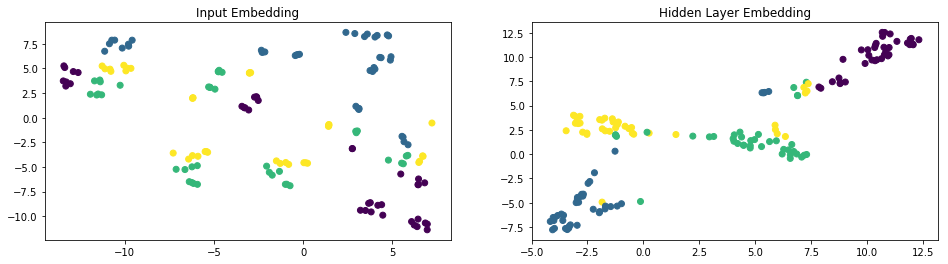

In [26]:
inputs, y, features = extract_hidden_features(hidden_features, validation_generator, N_val_images)


from sklearn.manifold import TSNE

plt.figure(figsize=(16,4))
plt.subplot(1,2,2)
features_embedded = TSNE(n_components=2).fit_transform(features)
plt.scatter(features_embedded[:,0], features_embedded[:,1], c=y)
plt.title('Hidden Layer Embedding')

plt.subplot(1,2,1)
inputs_embedded = TSNE(n_components=2).fit_transform(inputs)
plt.scatter(inputs_embedded[:,0], inputs_embedded[:,1], c=y)
plt.title('Input Embedding')

What does the above two plots tell you about overfitting?

## Try a deep CNN network

One important method that can be used to prevent CNN from overfitting to the training data, one can augment the images randomly. The image data generator can apply random image augmentations to data like: rotations, translation etc. Lets do some random rotations and translations. Note that Augmentations are not usually applied to test data.  

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last', 
                                   rotation_range=15, width_shift_range=0.2, 
                                   height_shift_range=0.2)
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 16

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory='./',
        x_col="image_path",
        y_col="label",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=validation_df,
        directory='./',
        x_col="image_path",
        y_col="label",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

Found 469 validated image filenames belonging to 4 classes.
Found 155 validated image filenames belonging to 4 classes.


In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.metrics import categorical_accuracy

model_cnn = Sequential()
model_cnn.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001), input_shape=(28, 28, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001)))
model_cnn.add(Activation('relu'))
# model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Conv2D(64, (3, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model_cnn.add(Dense(64))
model_cnn.add(Activation('relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(4))
model_cnn.add(Activation('softmax'))

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_cnn.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[categorical_accuracy])

model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        896       
_________________________________________________________________
activation_5 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
activation_6 (Activation)    (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          18496     
_________________________________________________________________
activation_7 (Activation)    (None, 9, 9, 64)          0

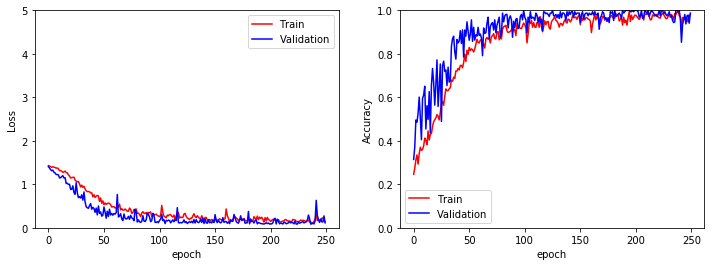

In [29]:
res = train_model(model_cnn, num_epoch=250, verbose=False)
plot_results(res)

In [30]:
# import boto3 
# import botocore 
# import pandas as pd 
# from sagemaker import get_execution_role 

# role = get_execution_role() 
# 's3://ml-assignment2-data/UCI-electricity/UCI_data.csv'
# bucket = 'ml-assignment2-data' 
# data_key = 'UCI-electricity/UCI_data.csv'
# data_location = 's3://{}/{}'.format(bucket, data_key) 

# pd.read_csv(data_location) 